In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

import gwspace.Constants as const

from gwspace.ORF import transfer_Dslr as Tslr
from gwspace.Orbit import get_pos
from gwspace.Waveform import SGWB

In [13]:
dt = 3600
tf = np.arange(0, const.YRSID_SI, dt)

xt_l, yt_l, zt_l, L_l = get_pos(tf, detector="LISA")
xt_tj, yt_tj, zt_tj, L_tj = get_pos(tf, detector="TaiJi")
xt_tq, yt_tq, zt_tq, L_tq = get_pos(tf, detector="TianQin")

In [35]:
def get_centre(x,y,z):
    return np.array([x[0]+x[1]+x[2],y[0]+y[1]+y[2],z[0]+z[1]+z[2]])/3

def get_theta(a, b, la, lb):
    costheta = (a[0]*b[0]+a[1]*b[1]+a[2]*b[2])/la/lb
    theta = np.arccos(costheta)
    return theta

def get_norm(a):
    return np.sqrt(a[0]**2+a[1]**2+a[2]**2)

In [36]:
pos_l = get_centre(xt_l,yt_l,zt_l)
pos_tj = get_centre(xt_tj,yt_tj,zt_tj)
pos_tq = get_centre(xt_tq,yt_tq,zt_tq)

R_l = get_norm(pos_l)
R_tj = get_norm(pos_tj)
R_tq = get_norm(pos_tq)

theta_ltj = get_theta(pos_l, pos_tj, R_l, R_tj)
theta_ltq = get_theta(pos_l, pos_tq, R_l, R_tq)
theta_tjtq = get_theta(pos_tj, pos_tq, R_tj, R_tq)

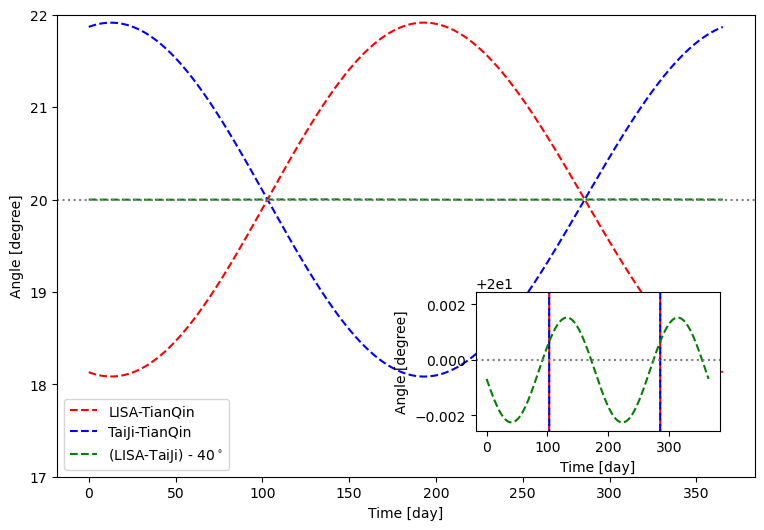

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

tt = tf/const.DAY

ax.plot(tt, theta_ltq/np.pi*180, '--r', label="LISA-TianQin")
ax.plot(tt, theta_tjtq/np.pi*180, '--b', label="TaiJi-TianQin")
ax.plot(tt, theta_ltj/np.pi*180-20, '--g', label=r"(LISA-TaiJi) - 40$^\circ$")

ax.axhline(20, color='gray', ls=':')

ax.set_ylim(17,22)

axins = ax.inset_axes((0.6, 0.1, 0.35, 0.3))
axins.plot(tt, theta_ltq/np.pi*180, '--r')
axins.plot(tt, theta_tjtq/np.pi*180, '--b')
axins.plot(tt, theta_ltj/np.pi*180-20, '--g')
axins.axhline(20, color='gray', ls=':')

axins.set_ylim(20-2.55e-3,20+2.45e-3)

ax.set_xlabel("Time [day]")
ax.set_ylabel("Angle [degree]")

axins.set_xlabel("Time [day]")
axins.set_ylabel("Angle [degree]")

ax.legend(loc='best')

plt.savefig("../../../TQ-SDS/figs/angle_sdb.pdf", dpi=360)

In [17]:
Tobs = const.DAYSID_SI*5 #const.YRSID_SI
dt = 1
df = 1/Tobs
fmax = 1/(2*dt)

Nsample = int(Tobs/dt)

#freq = np.arange(1,Nsample+1) * df
tf = np.arange(1, Nsample+1, dtype=np.double) * dt

freq = 10**np.linspace(-4,0,101)

def Sh(freq):
    Amp = 1e-9
    return Amp*freq**3

In [18]:
Nsample

430820

In [21]:
Npix = 192

sigma = np.sqrt(0.5*Sh(freq)/Npix)

hf = np.array([np.random.normal(0, sig, Npix) for sig in sigma])

amp = np.abs(hf)

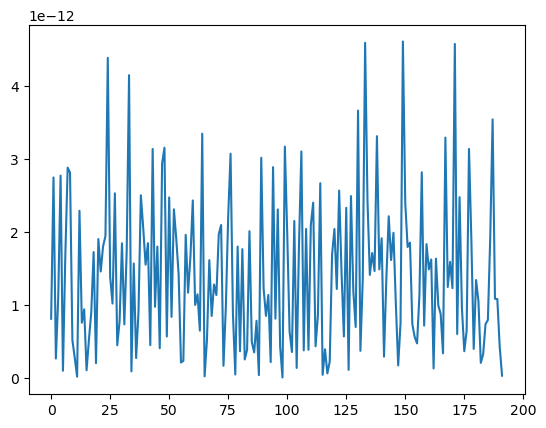

In [24]:
plt.plot(amp[0])

In [20]:
hf.shape

(101, 192)

In [25]:
theta,phi = np.load("../gwspace/theta_phi_4pix_192.npy")
lambd, beta = phi, np.pi/2-theta

In [29]:
Dslr_td = {}
zeta_l_td = {}

for i, ll, bb in zip(range(192), lambd, beta):
    for j, f in enumerate(freq[:2]):
        Dslr_td[(i,j)], zeta_l_td[(i,j)] = Tslr(tf, f, ll, bb)

KeyboardInterrupt: 

array([1., 1.])

In [55]:
def h(t, amp, f0):
    phi0 = np.random.uniform(0,2*np.pi)
    return amp*np.cos(2*np.pi*f0 *t + phi0)

def generate_amp(f, Sh_f):
    

In [70]:
lambd, beta = 0.3, 0.4

Tobs = const.DAYSID_SI*30 #const.YRSID_SI
dt = 1
df = 1/Tobs
fmax = 1/(2*dt)

Nsample = int(Tobs/dt)

freq = np.arange(1,Nsample+1) * df
tf = np.arange(1, Nsample+1, dtype=np.double) * dt

In [71]:
# for time and freq
yslr_td = Tslr(tf, 0.01, lambd, beta)

In [72]:
#plt.plot(tf, yslr[(1,2)].real)
yslr_td[(1,2)].shape, tf.shape

((2584922,), (2584922,))

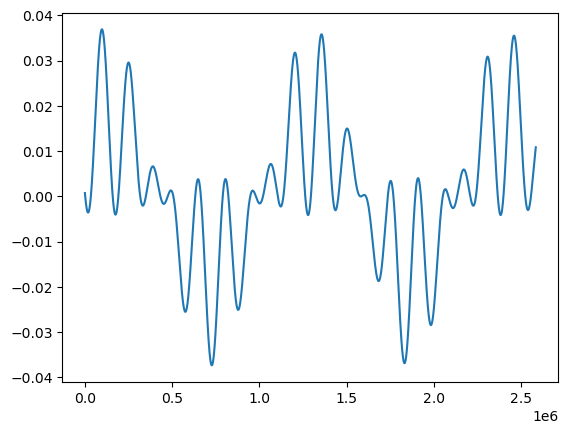

In [73]:
plt.plot(tf, yslr_td[(1,2)].real)

In [60]:
# for time and freq
yslr_fd = Tslr(np.array([1.0]), freq, lambd, beta)

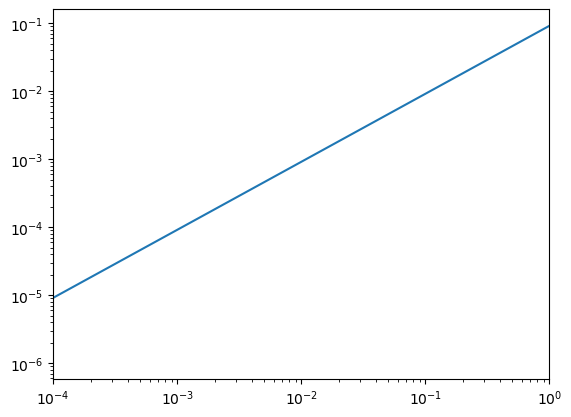

In [61]:
plt.plot(freq, np.abs(yslr_fd[(1,2)]))
plt.xlim(1e-4,1)
plt.xscale('log')
plt.yscale('log')

In [46]:
Tobs = const.YRSID_SI/360
dt = 1
df = 1/Tobs
fmax = 1/(2*dt)

Nsample = int(Tobs/dt)

freq = np.arange(1,Nsample+1) * df

Omega_f0 = 1e-12
Sh = Omega_f0 * freq/freq

In [47]:
sigma = (0.5 * Sh/df/4/np.pi/192)**0.5

hf = np.array([np.random.normal(0, sig, 192) for sig in sigma])

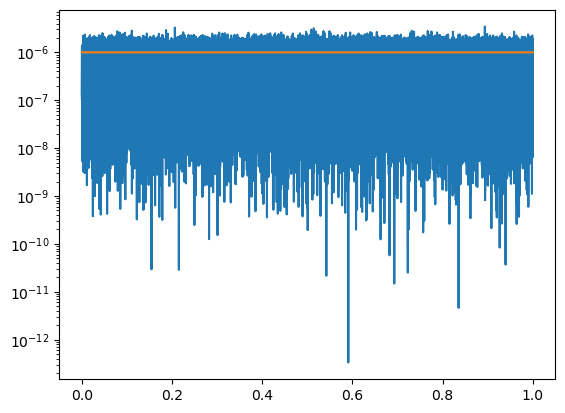

In [54]:
plt.plot(freq, np.abs(hf[:, 0]) *np.sqrt(df * 4*np.pi*192 ))

plt.plot(freq, np.sqrt(Sh))

plt.yscale('log')

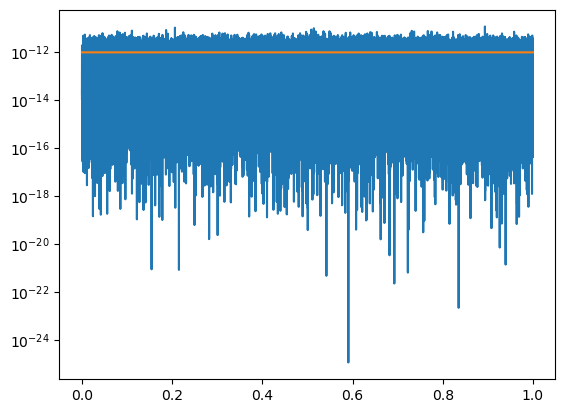

In [50]:
plt.plot(freq, hf[:, 0]*np.conjugate(hf[:,0]) *df * 4*np.pi*192 )

plt.plot(freq, Sh)

plt.yscale('log')

In [8]:
xx.shape

(4, 5)